# Executable Jupyter notebook 3: Medical data for classification

In [1]:
# imports and plotting utility functions
%matplotlib inline
import warnings

import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.discrete.discrete_model import Logit
from scipy.linalg import norm

warnings.simplefilter('ignore')

rf_cmp = RandomForestClassifier(n_estimators=250, bootstrap=True, oob_score=True, random_state=0)

def plot_lr(true_coefs, est_coefs, pvals, var_names=None, rf_cmp_coef=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(17, 6))
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, s=150, color='red', label='estimated betas', alpha=0.5)
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, s=150, color='black', label='true betas', alpha=0.5)
    if rf_cmp_coef is not None:
        plt.scatter(np.arange(X.shape[1]), rf_cmp_coef, s=150, marker='D', color='steelblue', label='RandomForest importances', alpha=0.5)

    # print star significant betas and their values
    axes = plt.gca()
    #import pdb; pdb.set_trace()
    y_min, y_max = axes.get_ylim()
    axes.set_ylim(y_min * 1.25, y_max * 1.25)
    sign_y = np.sum(where_sign) * [y_min]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)
    for i_b, p in enumerate(pvals):
        plt.text(x=i_b - 0.25, y=y_min * 1.10, s='$p$=%.3f' % p)

    plt.xlabel('input variables')
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1), fontsize=15)
    else:
        plt.xticks(np.arange(n_feat), var_names, fontsize=12, rotation=90)
    plt.grid(True)
    plt.title('Logistic regression', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, fancybox=True, framealpha=0.5)

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None, unbiased_accs=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid)[::-1],
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=11, markerscale=10, fancybox=True, framealpha=0.5)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('Penalized Logistic: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid)[::-1])
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    #import pdb; pdb.set_trace()
    if unbiased_accs is not None:
        axarr[1].scatter(np.arange(len(unbiased_accs)), unbiased_accs, color='orange',
                     linewidth=4, label='prediction accuracy (debiased)', zorder=10)
    axarr[1].scatter(np.arange(len(accs)), accs, color='black',
                     linewidth=3, label='prediction accuracy', zorder=10)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].legend(loc='lower left', fontsize=14, markerscale=1, fancybox=True, framealpha=0.5)
    axarr[1].set_title('Penalized Logistic: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

    
def corrfunc(x, y, **kws):
    from scipy import stats
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


/Users/dengeman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import statsmodels.api as sm

# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def fwd_stepwise_selection(X, y, initial_list=[], verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while len(included) < X.shape[1]:
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        best_feature = new_pval.argmin()
        included.append(best_feature)
        if verbose:
            print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
    return included

In [3]:
# statistical helper functions
def compute_Logistic_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    acc_unbiased_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_accs_unbiased = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = next(iter(folder))

            clf = LogisticRegression(C=my_C, random_state=i_subsample, penalty='l1')

            clf.fit(X[train_inds, :], y[train_inds])

            # compute out-of-sample prediction accuracy

            acc = average_precision_score(
                y_true=y[test_inds],
                y_score=clf.predict(X[test_inds]),
                average='weighted')
            
            # get out-of-sample accuracy from unbiased linear model with selected inputs
            b_vars_to_keep = np.squeeze(clf.coef_) != 0
            if np.sum(b_vars_to_keep) > 0:
                unbiased_lr = LogisticRegression(C=100000, random_state=i_subsample, penalty='l2')
                unbiased_lr.fit(
                  X[train_inds, :][:, b_vars_to_keep], y[train_inds])

                unbiased_acc = average_precision_score(
                    y_true=y[test_inds],
                    y_score=unbiased_lr.predict(X[test_inds][:, b_vars_to_keep]),
                    average='weighted')
            else:
                unbiased_acc = 0

            sample_accs.append(acc)
            sample_accs_unbiased.append(unbiased_acc)
            sample_coef.append(np.squeeze(clf.coef_))

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_at_step = np.mean(sample_accs)
        acc_list2.append(acc_at_step)
        acc_unbiased_list2.append(np.mean(sample_accs_unbiased))
        notzero = np.count_nonzero(mean_coefs)
        print("C: %.4f acc: %.2f active_coefs: %i" % (my_C, acc_at_step, notzero))
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2), np.array(acc_unbiased_list2)

# Heart dataset (ISL)

Dataset summary: These data contain a binary outcome HD for 303 patients who presented with chest pain (binary outcome). 

In [4]:
import pandas as pd
df_heart = pd.read_csv('dataset_heart_ISL.csv').fillna(value=0)
feat_names = ['Age', u'Sex', u'RestBP', u'Chol', u'Fbs',
       u'RestECG', u'MaxHR', u'ExAng', u'Oldpeak', u'Slope', u'Ca', u'Thal', u'ChestPain']
y = np.asarray(df_heart['AHD'] == 'Yes', dtype=np.int)

df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_heart[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_heart[feat_names[-2:]])
#pd.concat([df_part1, df_part2], axis=1)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)

cl2_prop = np.sum(y) * 100 / len(y)
print('Balance between class 1 : 2 is %.0f%% : %.0f%%' % (100 - cl2_prop, cl2_prop))

Balance between class 1 : 2 is 54% : 46%


In [5]:
df_heart

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
5,6,56,1,nontypical,120,236,0,0,178,0,0.8,1,0.0,normal,No
6,7,62,0,asymptomatic,140,268,0,2,160,0,3.6,3,2.0,normal,Yes
7,8,57,0,asymptomatic,120,354,0,0,163,1,0.6,1,0.0,normal,No
8,9,63,1,asymptomatic,130,254,0,2,147,0,1.4,2,1.0,reversable,Yes
9,10,53,1,asymptomatic,140,203,1,2,155,1,3.1,3,0.0,reversable,Yes


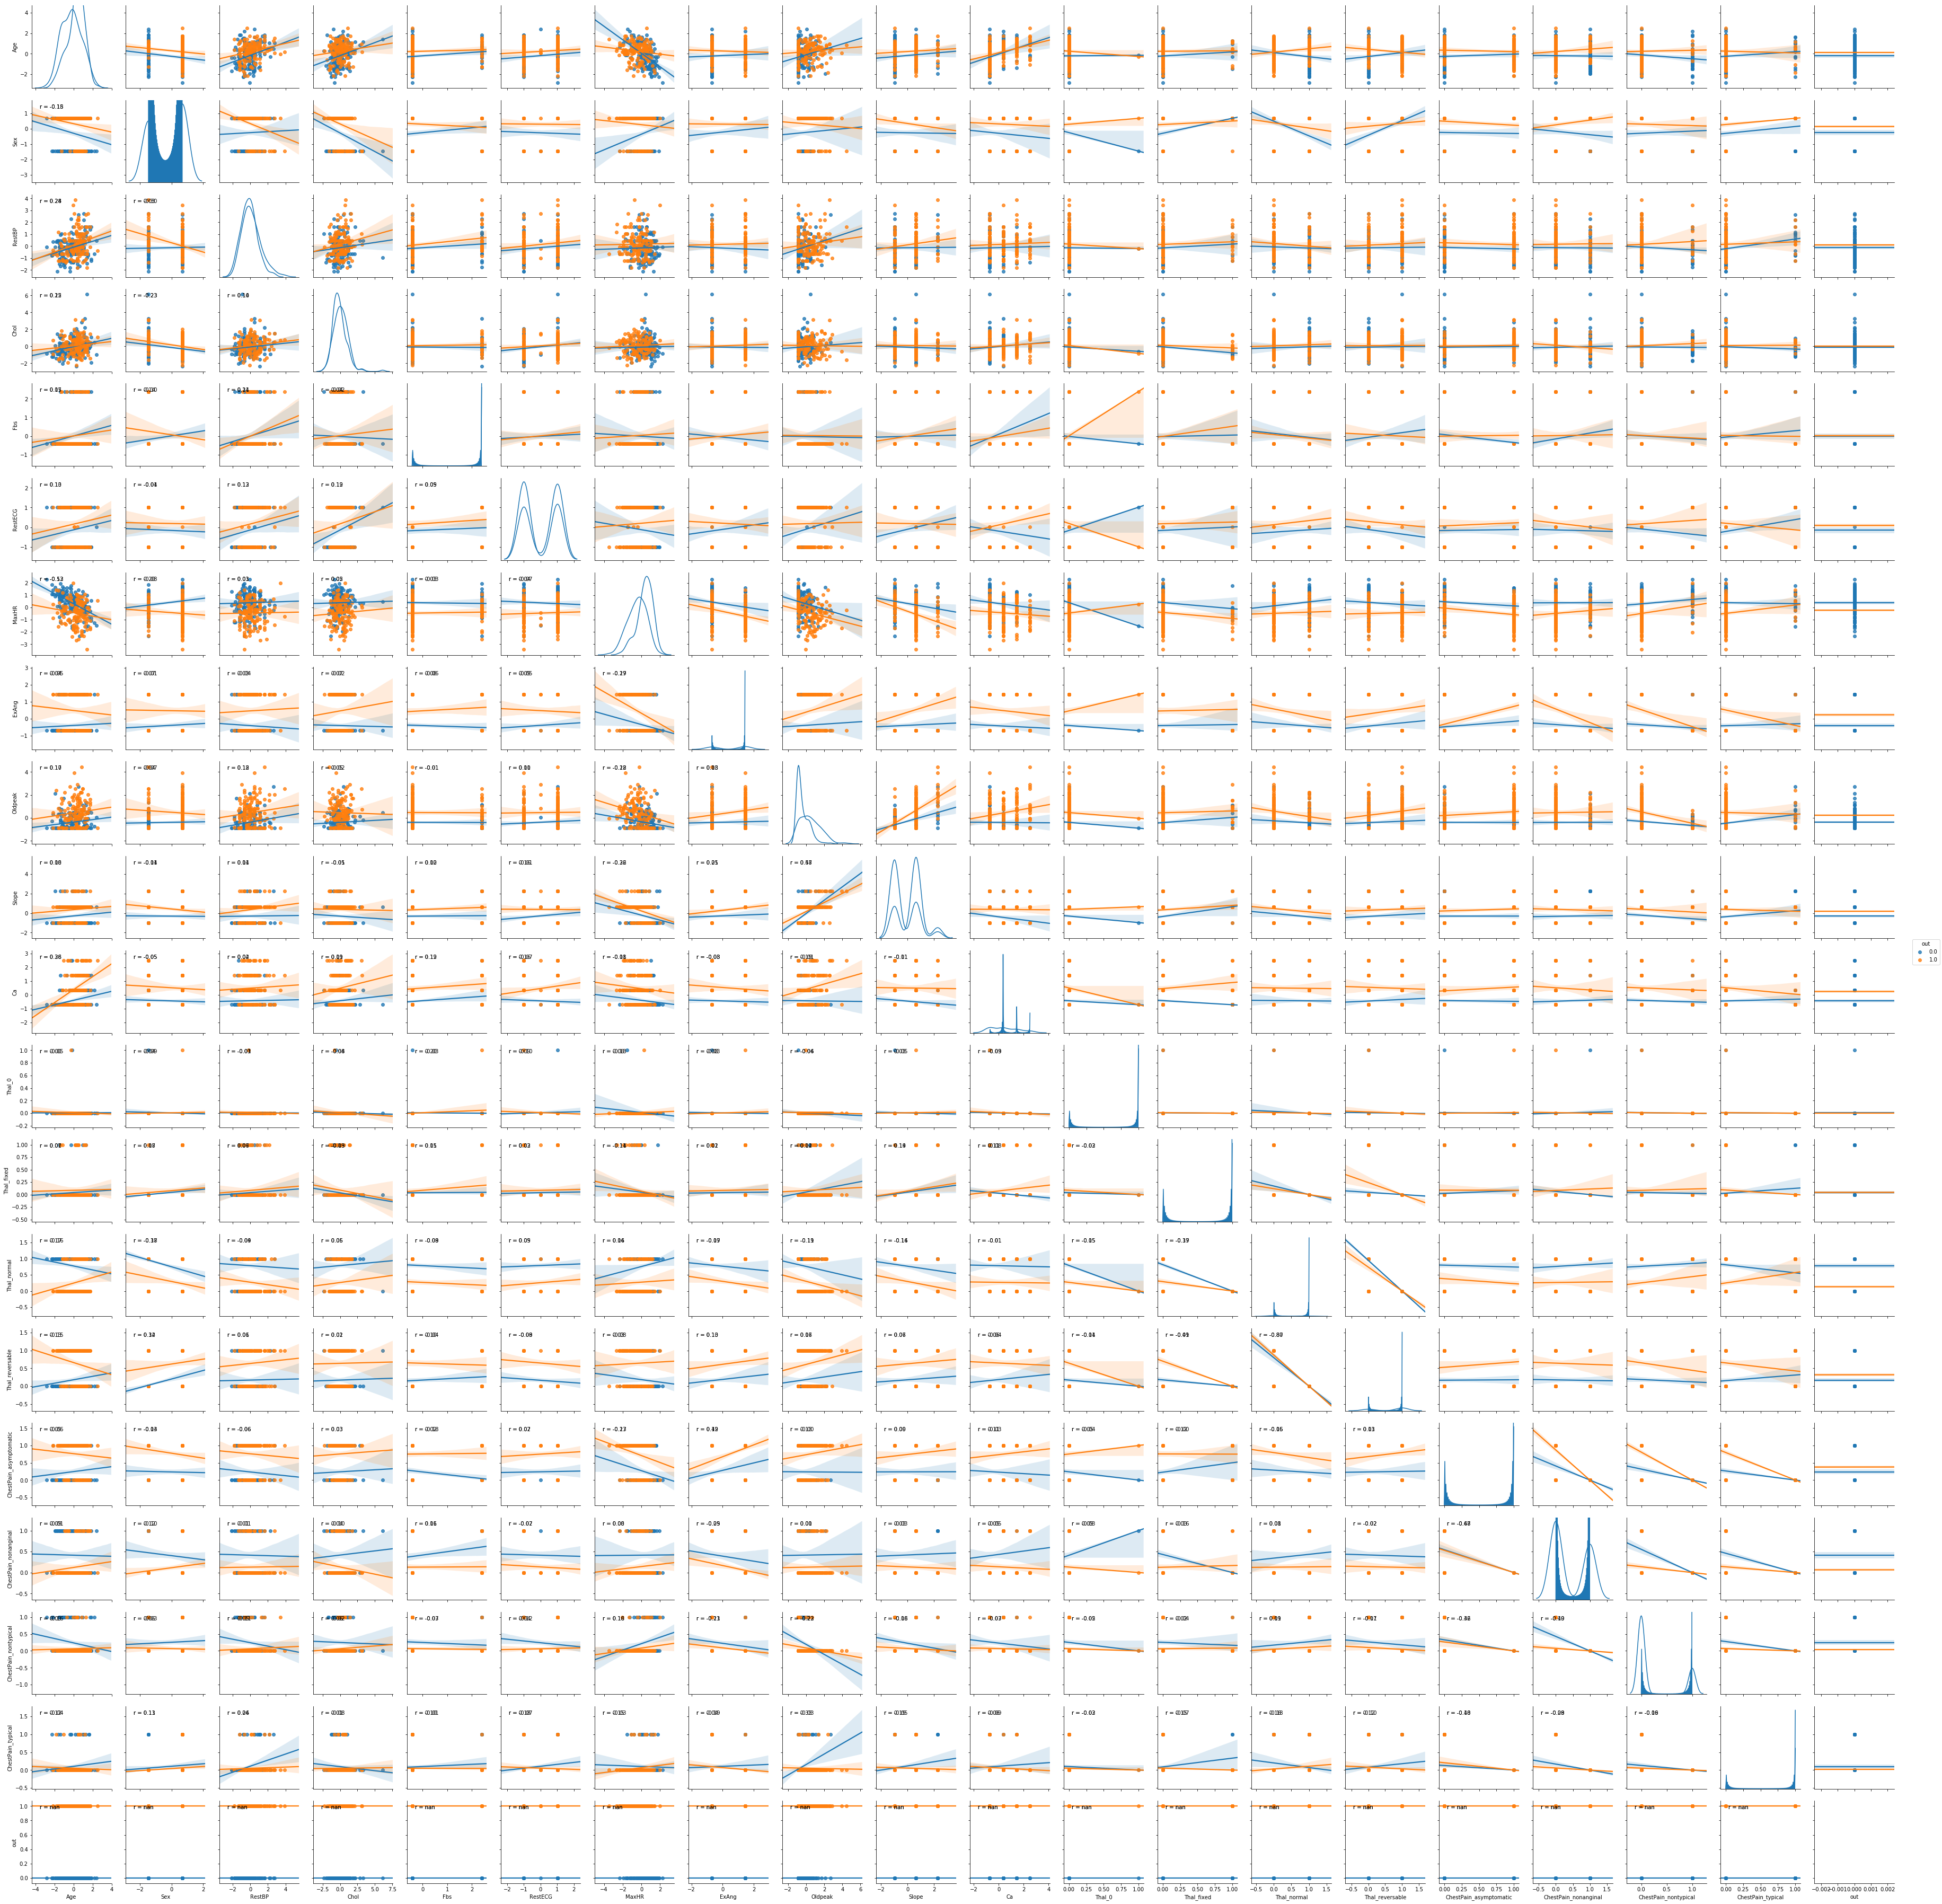

In [6]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
             kind="reg", diag_kind="kde", hue='out')
g.map_lower(corrfunc)

C: 10.0000 acc: 0.78 active_coefs: 19
C: 7.4989 acc: 0.78 active_coefs: 19
C: 5.6234 acc: 0.78 active_coefs: 19
C: 4.2170 acc: 0.78 active_coefs: 19
C: 3.1623 acc: 0.78 active_coefs: 19
C: 2.3714 acc: 0.78 active_coefs: 19
C: 1.7783 acc: 0.78 active_coefs: 17
C: 1.3335 acc: 0.78 active_coefs: 17
C: 1.0000 acc: 0.78 active_coefs: 17
C: 0.7499 acc: 0.78 active_coefs: 17
C: 0.5623 acc: 0.78 active_coefs: 17
C: 0.4217 acc: 0.78 active_coefs: 17
C: 0.3162 acc: 0.78 active_coefs: 15
C: 0.2371 acc: 0.78 active_coefs: 14
C: 0.1778 acc: 0.79 active_coefs: 14
C: 0.1334 acc: 0.79 active_coefs: 14
C: 0.1000 acc: 0.79 active_coefs: 13
C: 0.0750 acc: 0.77 active_coefs: 11
C: 0.0562 acc: 0.76 active_coefs: 9
C: 0.0422 acc: 0.74 active_coefs: 7
C: 0.0316 acc: 0.72 active_coefs: 7
C: 0.0237 acc: 0.70 active_coefs: 4
C: 0.0178 acc: 0.64 active_coefs: 4
C: 0.0133 acc: 0.47 active_coefs: 0
C: 0.0100 acc: 0.47 active_coefs: 0


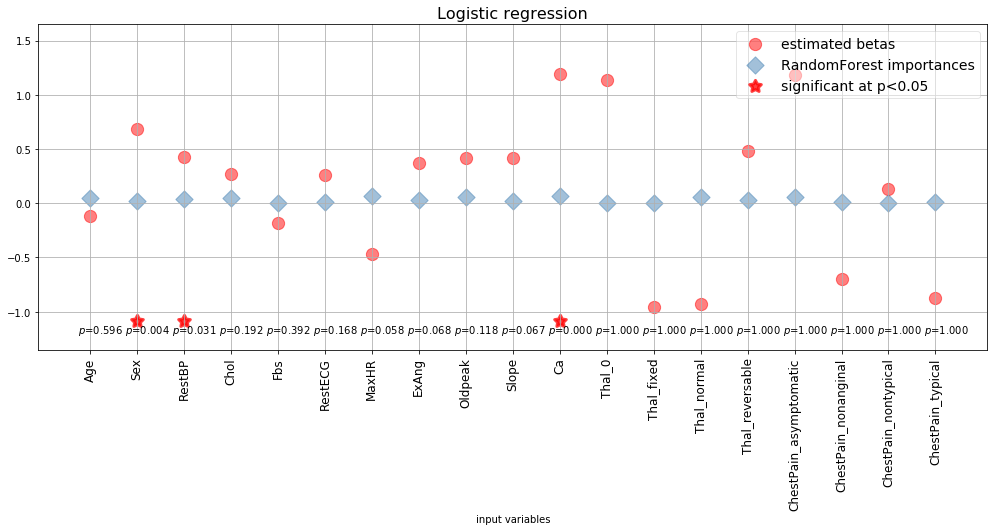

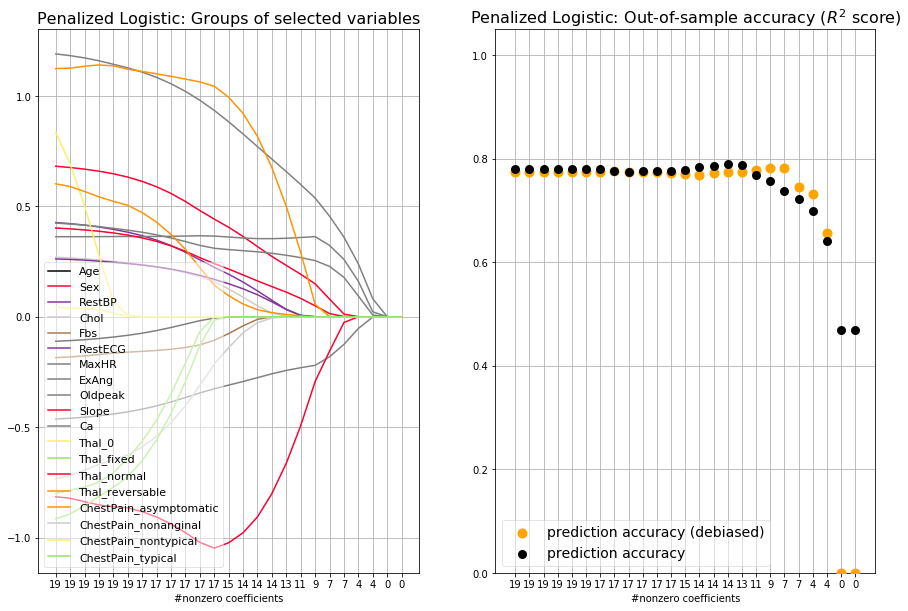

In [7]:
# ordinary linear model with logit loss
model = Logit(y, X)
res = model.fit(disp=0)
lr_coefs = res.params
lr_pvalues = res.pvalues

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute regularization paths of L1-penalized linear model with logit loss
C_grid = np.logspace(+1, -2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Logistic_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [8]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  Thal_normal                    with p-value 1.01554e-17
Add  ChestPain_asymptomatic         with p-value 8.76513e-12
Add  Ca                             with p-value 5.44918e-08
Add  Oldpeak                        with p-value 0.000292995
Add  ExAng                          with p-value 0.0177969
Add  RestECG                        with p-value 0.0487469
Add  Sex                            with p-value 0.0720185
Add  MaxHR                          with p-value 0.0784324
Add  RestBP                         with p-value 0.0625983
Add  Thal_fixed                     with p-value 0.062896
Add  Slope                          with p-value 0.116818
Add  ChestPain_nontypical           with p-value 0.0956932
Add  Chol                           with p-value 0.225965
Add  Fbs                            with p-value 0.414937
Add  Age                            with p-value 0.585244
Add  Thal_0                         with p-value 0.735713
Add  ChestPain_nonanginal           with p-value 0.782

In [9]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  303
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           17
Date:                Mon, 21 May 2018   Pseudo R-squ.:                  0.5285
Time:                        00:00:16   Log-Likelihood:                -98.548
converged:                       True   LL-Null:                       -208.99
                                        LLR p-value:                 1.745e-37
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age                       -0.1180      0.223     -0.530      0.596      -0.554       0.318
Sex                        0.6847      0.239      2.859      0.004       0.215       1.154
RestBP                     0.4237      0.196      2.161      0.031       0.039       0.808
Chol                       0.2679      0.205      1.305      0.192      -0.134       0.670
Fbs                       -0.1784      0.208     -0.856      0.392      -0.587       0.230
RestECG                    0.2583      0.187      1.379      0.168      -0.109       0.625
MaxHR                     -0.4647      0.245     -1.895      0.058      -0.946       0.016
ExAng                      0.3708      0.203      1.823      0.068      -0.028       0.769
Oldpeak                    0.4189      0.268      1.564      0.118      -0.106       0.944
Slope                      0.4164      0.228      1.830      0.067      -0.030       0.862
Ca                         1.1919      0.254      4.692      0.000       0.694       1.690
Thal_0                     1.1389   1.06e+07   1.08e-07      1.000   -2.07e+07    2.07e+07
Thal_fixed                -0.9576   1.06e+07  -9.05e-08      1.000   -2.07e+07    2.07e+07
Thal_normal               -0.9272   1.06e+07  -8.76e-08      1.000   -2.07e+07    2.07e+07
Thal_reversable            0.4805   1.06e+07   4.54e-08      1.000   -2.07e+07    2.07e+07
ChestPain_asymptomatic     1.1782   1.06e+07   1.11e-07      1.000   -2.07e+07    2.07e+07
ChestPain_nonanginal      -0.6998   1.06e+07  -6.62e-08      1.000   -2.07e+07    2.07e+07
ChestPain_nontypical       0.1346   1.06e+07   1.27e-08      1.000   -2.07e+07    2.07e+07
ChestPain_typical         -0.8784   1.06e+07   -8.3e-08      1.000   -2.07e+07    2.07e+07
==========================================================================================
"""

### conclusion: only 1 of 3 significant variables is among the 4 most predictive ones

# South African Heart dataset: many significant but one most predictive

Dataset summary (ESL): A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of coronary heart disease. Many of the coronary heart disease positive men have undergone blood pressure reduction treatment and other programs to reduce their risk
factors after their coronary heart disease event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal.

Based on this data, does having a family history of coronary heart disease affect a patients chance of having coronary heart disease? Does this result change for patients younger than 40 years old? What about for patients aged 40 years or older?

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

In [10]:
import pandas as pd
df_africa = pd.read_excel('dataset_south_african_heart_disease.xls')

df_africa

,row,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
5,6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
6,7,142,4.05,3.38,16.20,Absent,59,20.81,2.62,38,0
7,8,114,4.08,4.59,14.60,Present,62,23.11,6.72,58,1
8,9,114,0.00,3.83,19.40,Present,49,24.86,2.49,29,0
9,10,132,0.00,5.80,30.96,Present,69,30.11,0.00,53,1


In [11]:
feat_names = ['sbp', u'tobacco', u'ldl', u'adiposity', u'famhist', u'typea',
       u'obesity', u'alcohol', u'age']
df_africa['famhist'] = pd.get_dummies(df_africa['famhist'], drop_first=True)
X = StandardScaler().fit_transform(df_africa[feat_names].values)
y = df_africa['chd'].values

cl2_prop = np.sum(y) * 100 / len(y)
print('Balance between class 1 : 2 is %.0f%% : %.0f%%' % (100 - cl2_prop, cl2_prop))

Balance between class 1 : 2 is 65% : 35%


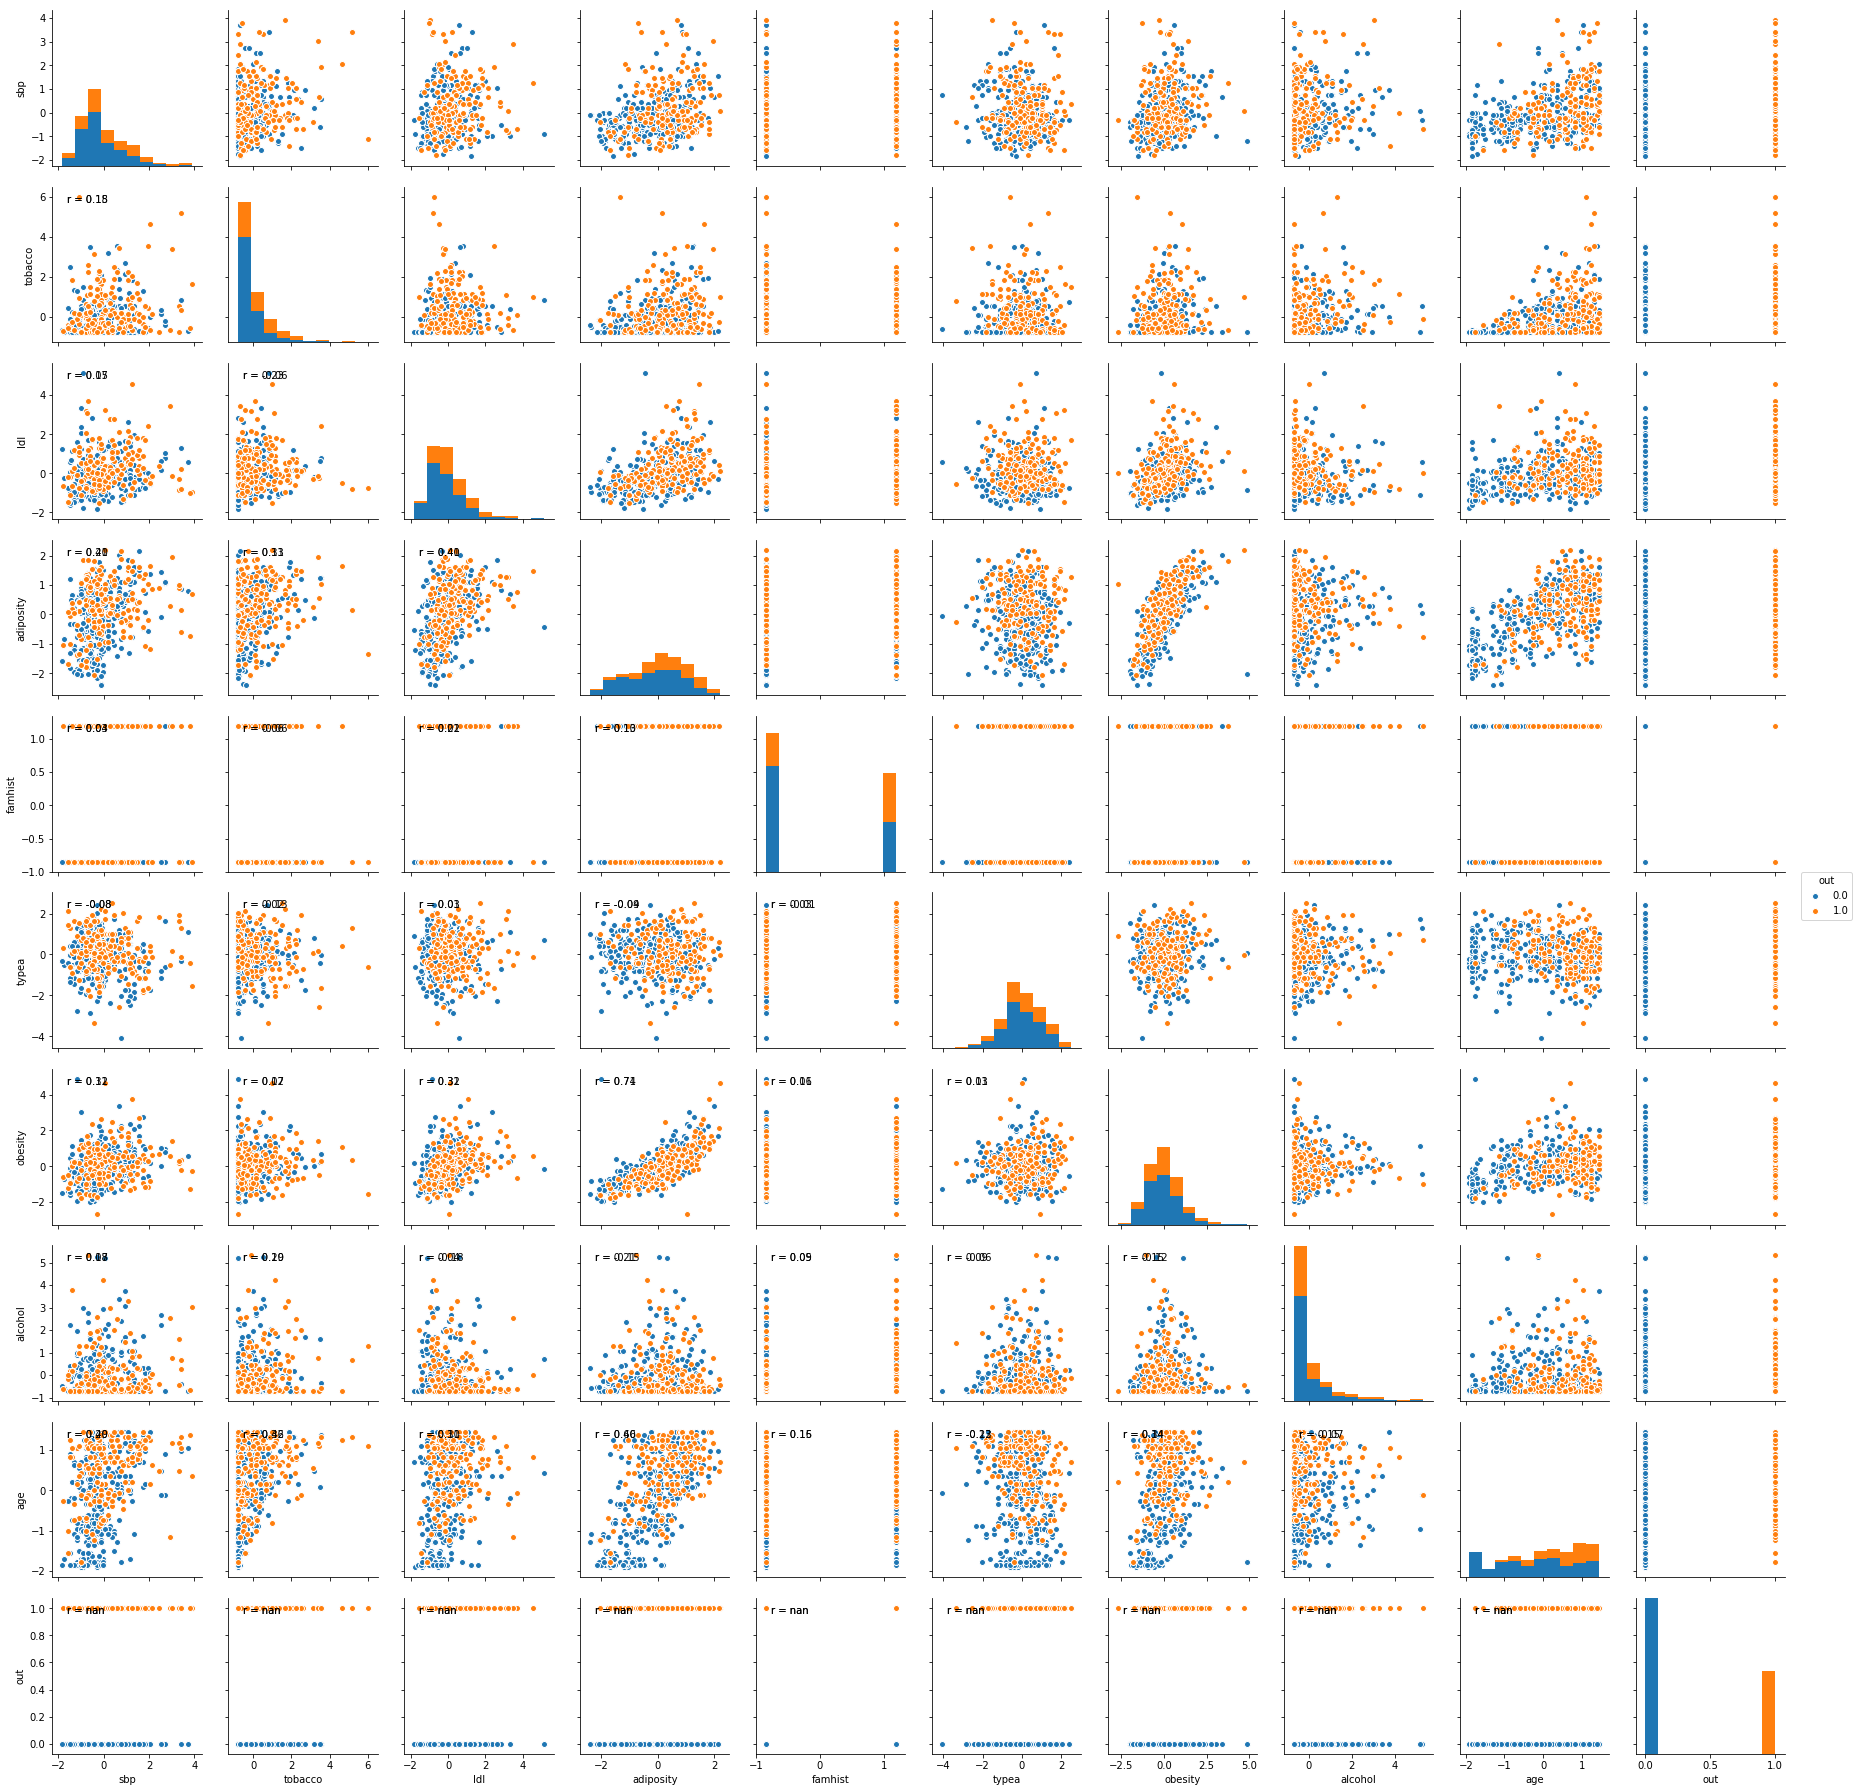

In [12]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
              hue='out')
g.map_lower(corrfunc)

C: 3.1623 acc: 0.50 active_coefs: 9
C: 2.4879 acc: 0.50 active_coefs: 9
C: 1.9573 acc: 0.50 active_coefs: 9
C: 1.5399 acc: 0.50 active_coefs: 9
C: 1.2115 acc: 0.50 active_coefs: 9
C: 0.9532 acc: 0.50 active_coefs: 9
C: 0.7499 acc: 0.50 active_coefs: 9
C: 0.5900 acc: 0.50 active_coefs: 9
C: 0.4642 acc: 0.51 active_coefs: 9
C: 0.3652 acc: 0.51 active_coefs: 9
C: 0.2873 acc: 0.51 active_coefs: 9
C: 0.2260 acc: 0.51 active_coefs: 9
C: 0.1778 acc: 0.51 active_coefs: 9
C: 0.1399 acc: 0.50 active_coefs: 9
C: 0.1101 acc: 0.50 active_coefs: 8
C: 0.0866 acc: 0.50 active_coefs: 8
C: 0.0681 acc: 0.50 active_coefs: 6
C: 0.0536 acc: 0.50 active_coefs: 6
C: 0.0422 acc: 0.50 active_coefs: 6
C: 0.0332 acc: 0.49 active_coefs: 5
C: 0.0261 acc: 0.47 active_coefs: 4
C: 0.0205 acc: 0.46 active_coefs: 4
C: 0.0162 acc: 0.46 active_coefs: 1
C: 0.0127 acc: 0.35 active_coefs: 1
C: 0.0100 acc: 0.35 active_coefs: 0


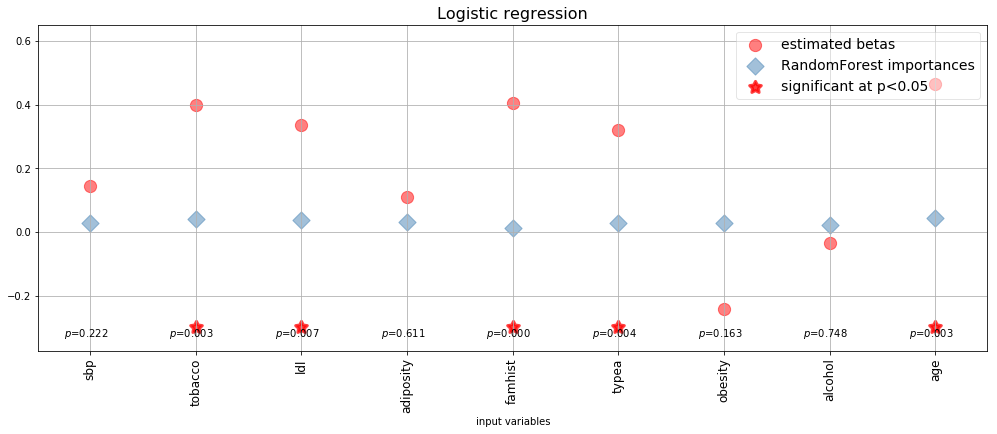

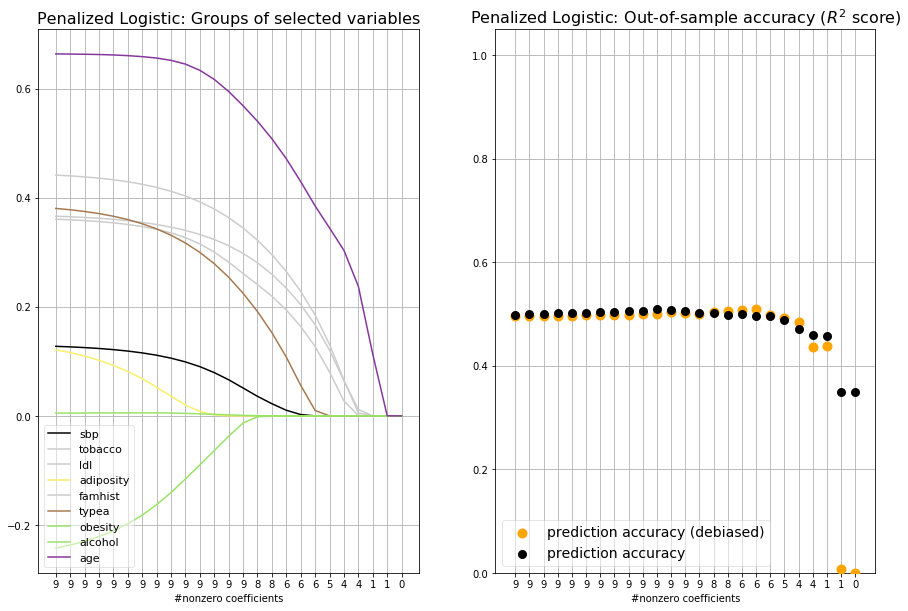

In [13]:
# ordinary linear model with logit loss
model = Logit(y, X)
res = model.fit(disp=0)
lr_coefs = res.params
lr_pvalues = res.pvalues

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute regularization paths of L1-penalized linear model with logit loss
C_grid = np.logspace(+.5, -2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Logistic_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [14]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  age                            with p-value 5.75792e-14
Add  famhist                        with p-value 1.57789e-05
Add  typea                          with p-value 0.00121621
Add  tobacco                        with p-value 0.00145147
Add  ldl                            with p-value 0.00320907
Add  obesity                        with p-value 0.196376
Add  sbp                            with p-value 0.232859
Add  adiposity                      with p-value 0.524079
Add  alcohol                        with p-value 0.97835
Forward-stepwise selection: age -> famhist -> typea -> tobacco -> ldl -> obesity -> sbp -> adiposity -> alcohol


### conclusion:
- 5 significant variables, but only 1 of them achieve comparable prediction in new patients
- the most predictive feature is the health aspect that we can change least - age

In [15]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            8
Date:                Mon, 21 May 2018   Pseudo R-squ.:                  0.1085
Time:                        00:00:35   Log-Likelihood:                -265.73
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 5.656e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sbp            0.1428      0.117      1.220      0.222      -0.087       0.372
tobacco        0.3971      0.132      3.006      0.003       0.138       0.656
ldl            0.3351      0.124      2.700      0.007       0.092       0.578
adiposity      0.1093      0.215      0.509      0.611      -0.311       0.530
famhist        0.4047      0.107      3.795      0.000       0.196       0.614
typea          0.3198      0.111      2.885      0.004       0.103       0.537
obesity       -0.2427      0.174     -1.395      0.163      -0.584       0.098
alcohol       -0.0344      0.107     -0.321      0.748      -0.244       0.175
age            0.4647      0.158      2.942      0.003       0.155       0.774
==============================================================================
"""

# Coronary Heart Disease: 4 significant, but 1 most predictive

Dataset summary: This dataset is from the Duke University Cardiovascular Disease Databank and consists of 3504 patients and 6 variables. The patients were referred to Duke University Medical Center for chest pain. Some interesting analyses include predicting the probability of significant (>= 75% diameter narrowing in at least one important coronary artery) coronary disease, and predicting the probability of severe coronary disease given that some significant disease is "ruled in." The first analysis would use sigdz as a response variable, and the second would use tvdlm on the subset of patients having sigdz=1. Severe coronary disease is defined as three-vessel or left main disease and is denoted by tvdlm=1. sex=0 for males, 1 for females.

3504 observations and 6 variables

![image.png](attachment:image.png)

In [16]:
import pandas as pd
df_coro = pd.read_excel('dataset_coronary_catheder.xls').dropna(how='any')

df_coro

*** No CODEPAGE record, no encoding_override: will use 'ascii'


,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
7,0,41,15,247.0,1,0.0
11,0,35,44,257.0,0,0.0
13,0,58,7,168.0,1,0.0
14,0,81,2,246.0,1,1.0
15,0,58,79,221.0,1,1.0
17,0,47,6,272.0,1,0.0


In [17]:
feat_names = ['sex', 'age', 'cad.dur', 'choleste']
feat_continuous = ['age', 'cad.dur', 'choleste']
df_coro[feat_continuous] = StandardScaler().fit_transform(df_coro[feat_continuous])
#y = df_coro['tvdlm'].values
y = df_coro['sigdz'].values
df_coro = df_coro[feat_names]
X = df_coro.values

cl2_prop = np.sum(y) * 100 / len(y)
print('Balance between class 1 : 2 is %.0f%% : %.0f%%' % (100 - cl2_prop, cl2_prop))

Balance between class 1 : 2 is 34% : 66%


C: 1.0233 acc: 0.76 active_coefs: 4
C: 0.7666 acc: 0.76 active_coefs: 4
C: 0.5743 acc: 0.76 active_coefs: 4
C: 0.4303 acc: 0.76 active_coefs: 4
C: 0.3224 acc: 0.76 active_coefs: 4
C: 0.2415 acc: 0.76 active_coefs: 4
C: 0.1809 acc: 0.76 active_coefs: 4
C: 0.1355 acc: 0.76 active_coefs: 4
C: 0.1015 acc: 0.76 active_coefs: 4
C: 0.0761 acc: 0.75 active_coefs: 4
C: 0.0570 acc: 0.75 active_coefs: 4
C: 0.0427 acc: 0.75 active_coefs: 4
C: 0.0320 acc: 0.75 active_coefs: 3
C: 0.0240 acc: 0.75 active_coefs: 3
C: 0.0180 acc: 0.74 active_coefs: 3
C: 0.0135 acc: 0.73 active_coefs: 3
C: 0.0101 acc: 0.69 active_coefs: 3
C: 0.0075 acc: 0.67 active_coefs: 3
C: 0.0057 acc: 0.66 active_coefs: 1
C: 0.0042 acc: 0.66 active_coefs: 0
C: 0.0032 acc: 0.66 active_coefs: 0
C: 0.0024 acc: 0.66 active_coefs: 0
C: 0.0018 acc: 0.66 active_coefs: 0
C: 0.0013 acc: 0.66 active_coefs: 0
C: 0.0010 acc: 0.66 active_coefs: 0


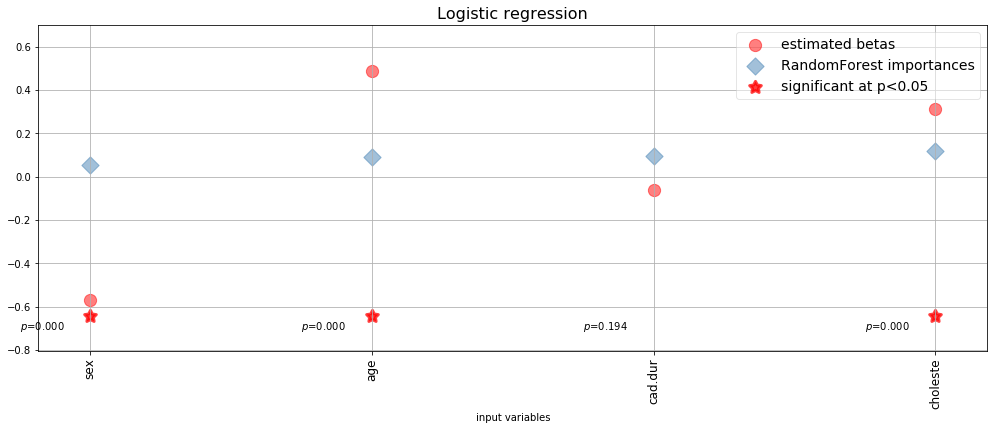

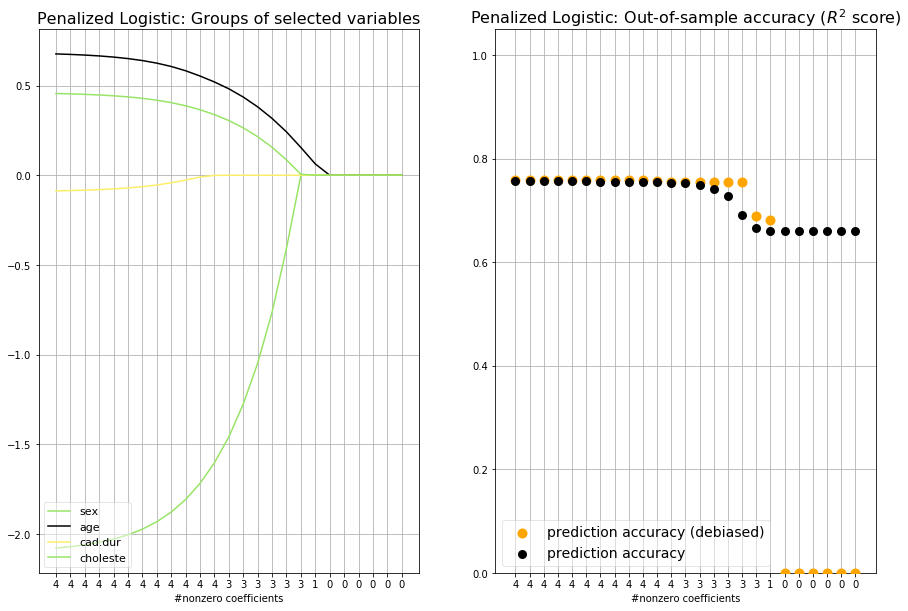

In [18]:
# ordinary linear model with logit loss
model = Logit(y, X)
res = model.fit(disp=0)
lr_coefs = res.params
lr_pvalues = res.pvalues

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute regularization paths of L1-penalized linear model with logit loss
C_grid = np.logspace(+.01, -3, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Logistic_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [19]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  sex                            with p-value 6.06864e-65
Add  age                            with p-value 8.65825e-34
Add  choleste                       with p-value 5.9199e-17
Add  cad.dur                        with p-value 0.0944686
Forward-stepwise selection: sex -> age -> choleste -> cad.dur


In [20]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2258
Model:                          Logit   Df Residuals:                     2254
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 May 2018   Pseudo R-squ.:                -0.01608
Time:                        00:00:50   Log-Likelihood:                -1470.9
converged:                       True   LL-Null:                       -1447.6
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex           -0.5702      0.083     -6.903      0.000      -0.732      -0.408
age            0.4863      0.049      9.969      0.000       0.391       0.582
cad.dur       -0.0598      0.046     -1.300      0.194      -0.150       0.030
choleste       0.3118      0.045      6.868      0.000       0.223       0.401
==============================================================================
"""

# Excercise

Compare infrerence with prediction using the infpred plot from the notebook on regression problems.